# Linear Elasticity Problem with Non-mixed Element Method

## The Variational Formulation (Pure Displacement Formulation)
This section describes the variational formulation of the linear elasticity problem in a pure displacement formulation. The problem is defined on a domain $\Omega$ with boundary $\partial\Omega$, where we seek to find a displacement field $u$ that satisfies the equilibrium equations under given boundary conditions. 

This leads to the following variational formulation:

$$
\boxed{
\begin{aligned}
&\text{Find } u \in V \text{ such that:} \\
&\qquad a(u, v) = L(v) \quad \forall v \in V
\end{aligned}
}
$$

with

$$
\begin{aligned}
&a : 
\begin{cases}
V \times V \rightarrow \mathbb{R} \\
(u, v) \longmapsto \int_\Omega \sigma (u) : \boldsymbol{\varepsilon}(v) \, dx
\end{cases} \\[0.3cm]
&L : 
\begin{cases}
V \rightarrow \mathbb{R} \\
v \longmapsto \int_\Omega f \cdot v \, dx + \int_{\partial\Omega_T} g_T \cdot v \, ds
\end{cases}
\end{aligned}
$$


This variational formulation is essential for solving linear elasticity problems numerically using PSYDAC.

## Formal Model

In [1]:
from sympde.expr import BilinearForm, LinearForm, integral
from sympde.expr     import find, EssentialBC, Norm, SemiNorm
from sympde.topology import VectorFunctionSpace, Cube, element_of, Union, NormalVector
from sympde.calculus import grad, inner, div, Transpose
from sympde.core import Constant
from sympde.core import Matrix

from sympy import Identity, Tuple, sin, pi, cos

from psydac.api.discretization import discretize


domain = Cube()
Gamma_DH = Union(domain.get_boundary(axis=2,ext=-1),domain.get_boundary(axis=2,ext=1))
Gamma_DNH = Union(domain.get_boundary(axis=0,ext=-1),domain.get_boundary(axis=0,ext=1))
Gamma_N = domain.boundary.complement(Union(Gamma_DH, Gamma_DNH))

nn = NormalVector(domain.boundary)


lambda_ = Constant('lambda_', real=True)
mu   = Constant('mu',   real=True)

epsilon = lambda w: 0.5*(grad(w) + Transpose(grad(w)))
sigma = lambda w: lambda_ * div(w) * Identity(3) + 2 * mu * epsilon(w)

V = VectorFunctionSpace('V', domain)

x,y,z = domain.coordinates

u,v = [element_of(V, name=i) for i in ['u', 'v']]


# # bilinear form
a = BilinearForm((u,v), integral(domain , inner(sigma(u), epsilon(v))))

mu_val=1.
lambda_val=1.25

# Exact solution
ue1 = 0
ue2 = 0
ue3 = cos(pi*x)*cos(pi*y)*sin(pi*z)
ue = Tuple(ue1, ue2, ue3)

#Source term
f1 = pi*pi * (lambda_ + mu) *   sin(pi*x) * cos(pi*y) * cos(pi*z)
f2 = pi*pi * (lambda_ + mu) *   cos(pi*x) * sin(pi*y) * cos(pi*z)
f3 = pi*pi * (4*mu + lambda_) * cos(pi*x) * cos(pi*y) * sin(pi*z)
f = Tuple(f1, f2, f3)
t = Tuple(0, -pi * lambda_ * cos(pi*x) * cos(pi*z), 0)
gi = ue

# linear forms
l = LinearForm(v, integral(domain, inner(f, v)))
ln = LinearForm(v, integral(Gamma_N, inner(t, v)))

# Dirichlet boundary conditions
bc = [EssentialBC(u, 0, Gamma_DH)]
bc += [EssentialBC(u, gi, Gamma_DNH)]  

# Variational problem
equation = find(u, forall=v, lhs=a(u, v), rhs=l(v)+ln(v), bc=bc)

## Discretization

We shall need the **discretize** function from **PsyDAC**.

In [2]:
d = 2 # discretization parameters
degree = [d,d,d]
h = 6
ncells = [h,h,h]

In [3]:
# Create computational domain from topological domain
domain_h = discretize(domain, ncells=ncells, comm=None)

# Create discrete spline space
Vh = discretize(V, domain_h, degree=degree)

# Discretize equation
equation_h = discretize(equation, domain_h, [Vh, Vh])

## Solving the PDE

In [4]:
equation_h.set_solver('gmres', info=False, tol=1e-8)
uh = equation_h.solve(mu=mu_val, lambda_=lambda_val)

## Computing the $L^2$ norm

In [5]:
u = element_of(V, name='u')

error = Matrix([u[0]-ue[0], u[1]-ue[1], u[2]-ue[2]])

# create the formal Norm object
l2norm = Norm(error, domain, kind='l2')

# discretize the norm
l2norm_h = discretize(l2norm, domain_h, Vh)

# assemble the norm
l2_error = l2norm_h.assemble(u=uh)

print(l2_error)

0.0004656873626406188


## Computing the $H^1$ semi-norm

In [6]:
# create the formal Norm object
h1_seminorm = SemiNorm(error, domain, kind='h1')

# discretize the norm
h1_seminorm_h = discretize(h1_seminorm, domain_h, Vh)

# assemble the norm
h1_semierror = h1_seminorm_h.assemble(u=uh)

print(h1_semierror)

0.020404882156184263


## Computing the $H^1$ norm

In [7]:
# create the formal Norm object
h1norm = Norm(error, domain, kind='h1')

# discretize the norm
h1norm_h = discretize(h1norm, domain_h, Vh)

# assemble the norm
h1_error = h1norm_h.assemble(u=uh)

print(h1_error)

0.02041019550439167


## Plotting the simulation results, exact solution and error

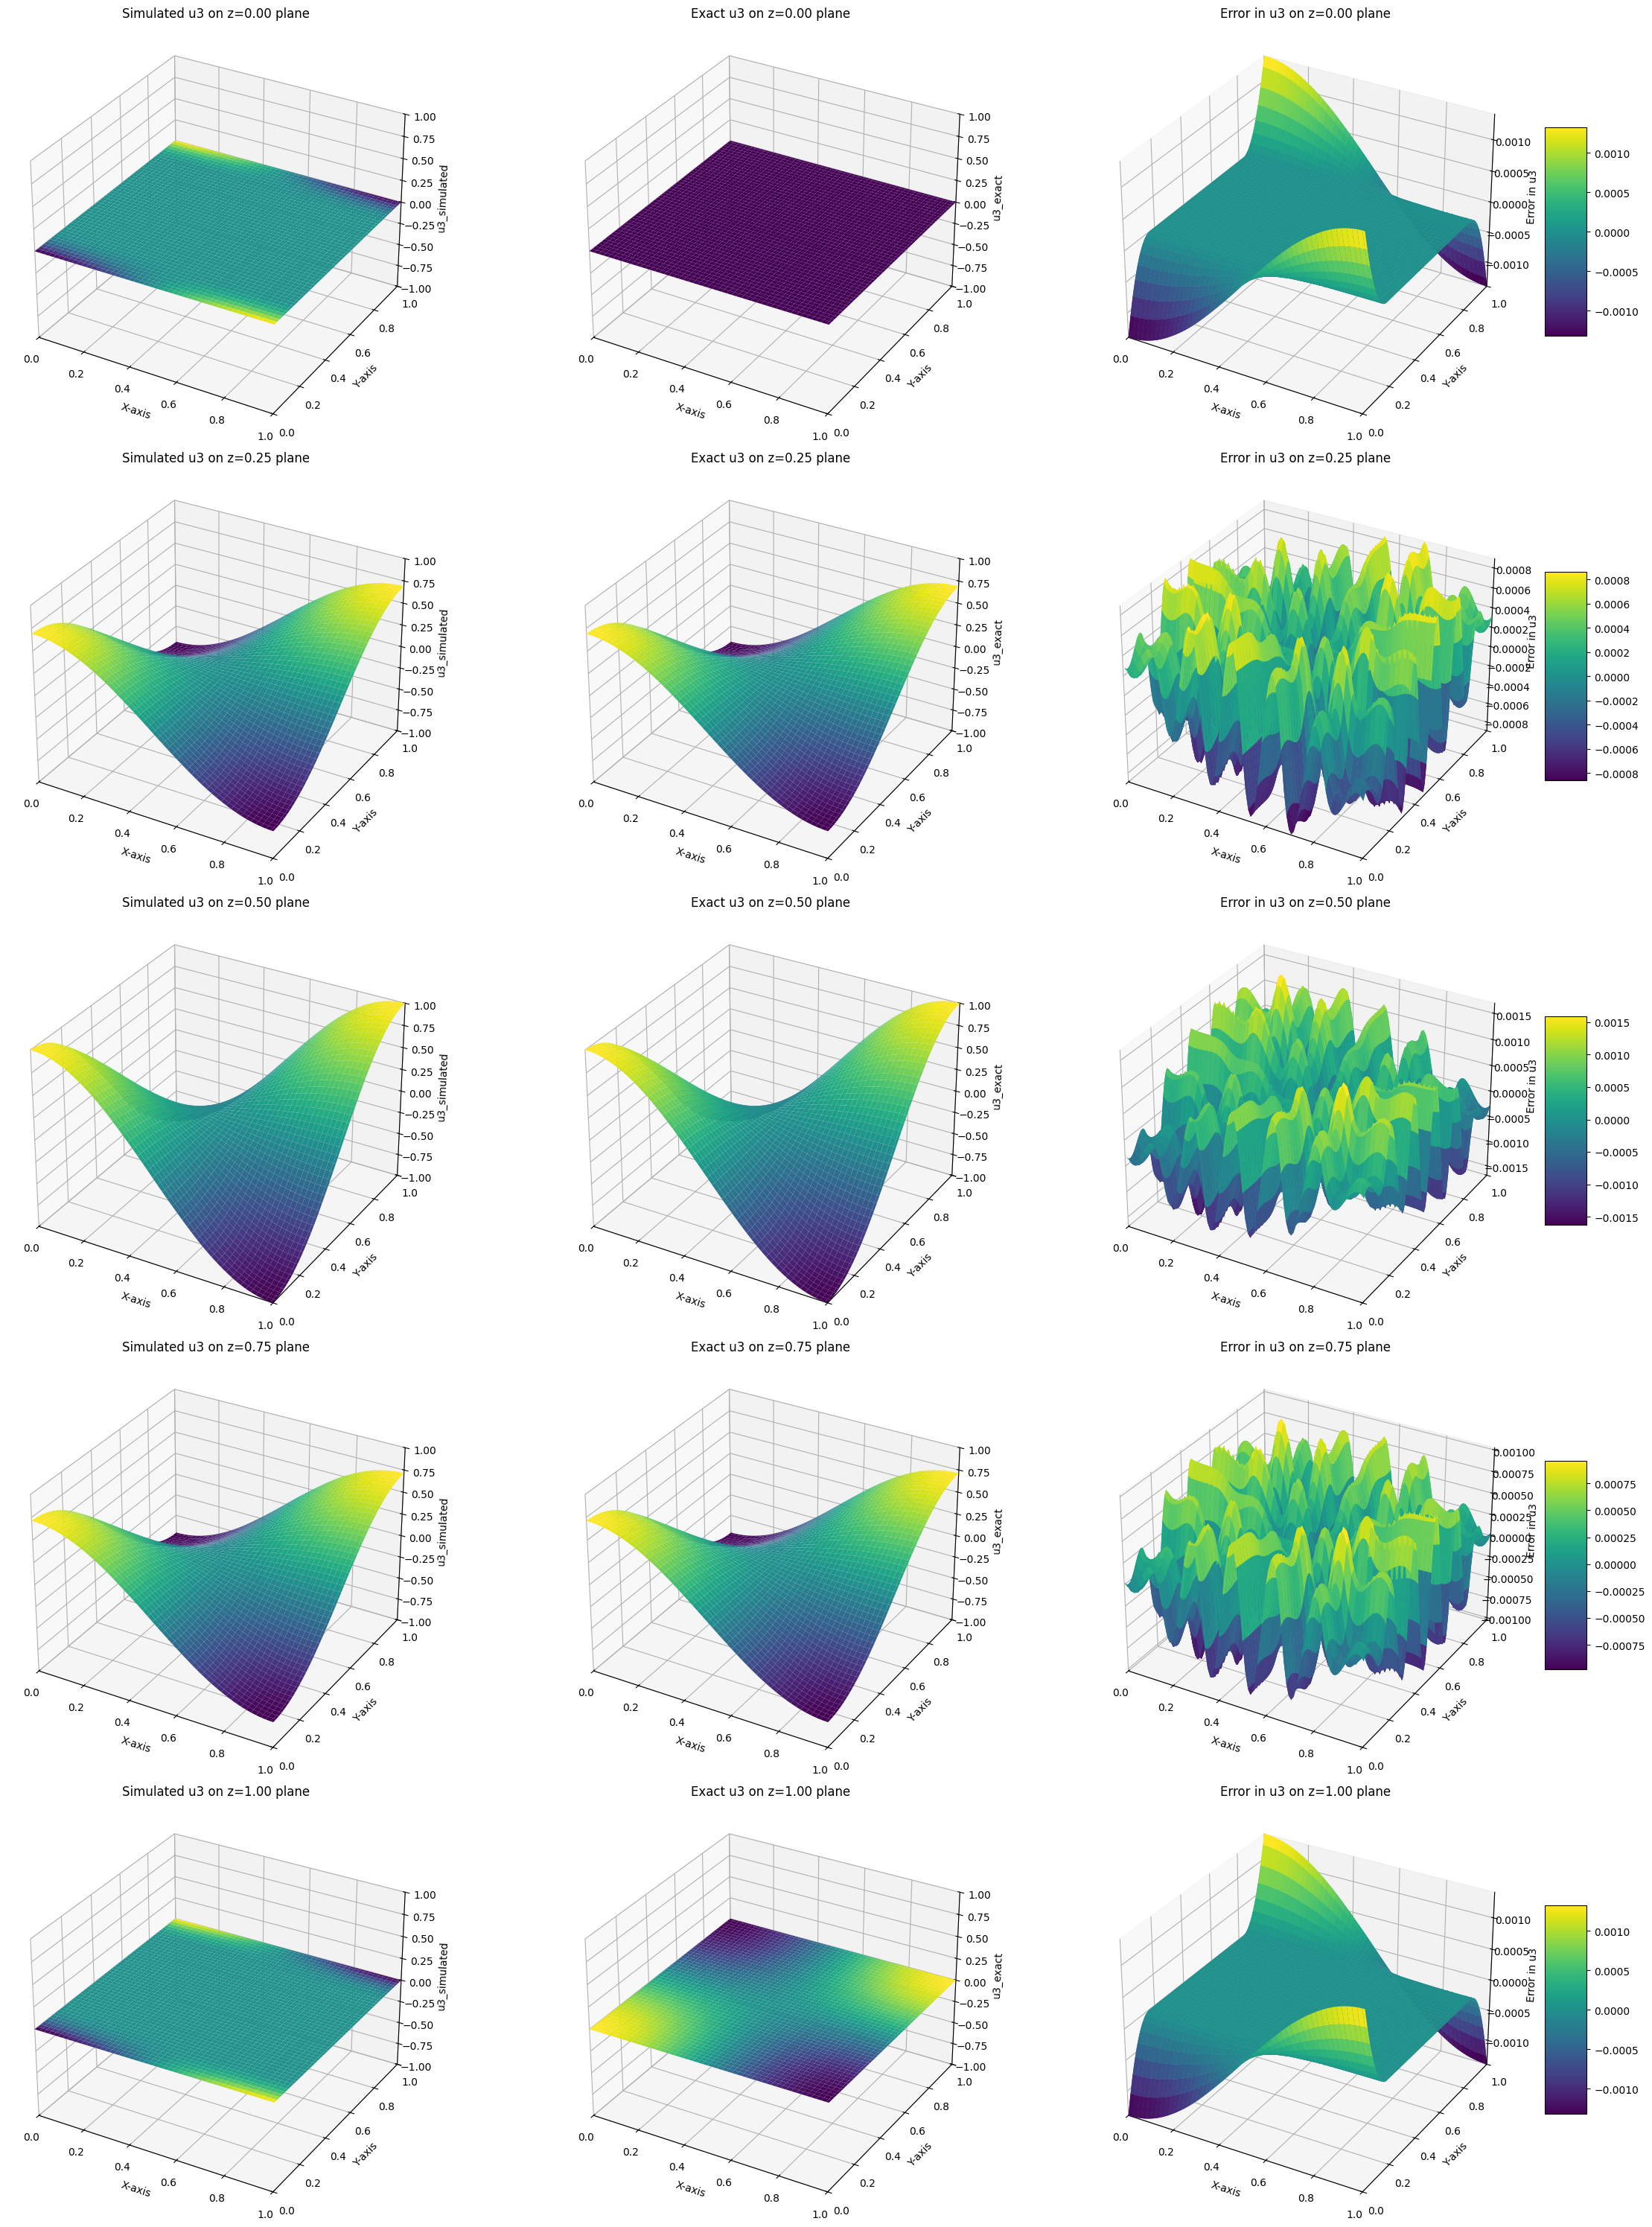

In [8]:
# %% plotting exact solution, simulation solution and error
import matplotlib.pyplot as plt
import numpy as np

h = 100
# Create a grid for plotting
x_vals = np.linspace(0, 1, h)
y_vals = np.linspace(0, 1, h)
z_vals = np.linspace(0, 1, h)
X, Y, Z = np.meshgrid(x_vals, y_vals, z_vals)
x_lim = 1
y_lim = 1
z_lim = 1

# Calculate the exact solution on the grid
exact_u1 = np.zeros_like(X)
exact_u2 = np.zeros_like(Y)
exact_u3 = np.cos(np.pi * X) * np.cos(np.pi * Y) * np.sin(np.pi * Z)

# Calculate simulated solution on the grid
u_simulated = Vh.eval_field(uh, x_vals, y_vals, z_vals)
u1 = u_simulated[0]
u2 = u_simulated[1]
u3 = u_simulated[2]

# Calculate the error
error_u1 = u1 - exact_u1
error_u2 = u2 - exact_u2
error_u3 = u3 - exact_u3



# %%
z_plane_list = np.linspace(0, 1, 5)  # List of z-planes to plot
fig = plt.figure(figsize=(24, 6 * len(z_plane_list)))

for i, z_plane in enumerate(z_plane_list):
    list_index = int(z_plane * (h - 1))  # Index for the z-plane

    # Simulated u3
    ax1 = fig.add_subplot(len(z_plane_list), 3, 3 * i + 1, projection='3d')
    ax1.plot_surface(X[:, :, list_index], Y[:, :, list_index], u3[:, :, list_index], cmap='viridis')
    ax1.set_title('Simulated u3 on z={:.2f} plane'.format(z_plane))
    ax1.set_xlabel('X-axis')
    ax1.set_ylabel('Y-axis')
    ax1.set_zlabel('u3_simulated')
    ax1.set_xlim(0, x_lim)
    ax1.set_ylim(0, y_lim)
    ax1.set_zlim(-z_lim, z_lim)

    # Exact u3
    ax2 = fig.add_subplot(len(z_plane_list), 3, 3 * i + 2, projection='3d')
    ax2.plot_surface(X[:, :, list_index], Y[:, :, list_index], exact_u3[:, :, list_index], cmap='viridis')
    ax2.set_title('Exact u3 on z={:.2f} plane'.format(z_plane))
    ax2.set_xlabel('X-axis')
    ax2.set_ylabel('Y-axis')
    ax2.set_zlabel('u3_exact')
    ax2.set_xlim(0, x_lim)
    ax2.set_ylim(0, y_lim)
    ax2.set_zlim(-z_lim, z_lim)

    # Error in u3
    ax3 = fig.add_subplot(len(z_plane_list), 3, 3 * i + 3, projection='3d')
    ax3.plot_surface(X[:, :, list_index], Y[:, :, list_index], error_u3[:, :, list_index], cmap='viridis')
    ax3.set_title('Error in u3 on z={:.2f} plane'.format(z_plane))
    ax3.set_xlabel('X-axis')
    ax3.set_ylabel('Y-axis')
    ax3.set_zlabel('Error in u3')
    ax3.set_xlim(0, x_lim)
    ax3.set_ylim(0, y_lim)
    ax3.set_zlim(error_u3[:, :, list_index].min(), error_u3[:, :, list_index].max())
    mappable = ax3.plot_surface(X[:, :, list_index], Y[:, :, list_index], error_u3[:, :, list_index], cmap='viridis')
    fig.colorbar(mappable, ax=ax3, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()